# Cubic spline interpolation example

We will try to dxperiment with the cubic interpolation splines for three sets of data:

1. $f(x)=x\ln(x)$ Exercise from Burden and Farires Numerical Analysis
2. The superposition of a reference signal and a trend (Boris et. al 2020)
   \begin{align*}
   I_R &= A\cdot e^{-\frac{(t-t_m)^2}{2d_t^2}}\cdot \sum^{n}_{i}\sin(\omega_i t) \\
   T(t) &= B\cdot|t-t_0|^3 
   \end{align*}
   where I_R is the reference signal, T(t) is the trend, $t_m$ is a parameter that determines the position of the wave packet envelope maximum, $d_t$ is the half width of the envelope, $\omega_i$ are three harmonics with amplitude $A$, $t_0$ is the position of the trend minimum and $B$ is the amplitude of the trend.
3. TEC data from ARTU station (Chelyabinsk event)   

## Logarithmic function

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import seaborn as sns

In [259]:
x = np.logspace(-6, 1)
y = x*np.log(x)

In [260]:
S = CubicSpline(x, y)

Text(0.5, 1.0, '$f(x)=x\\ln x$')

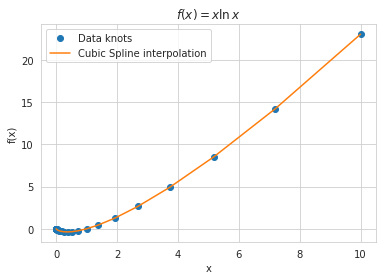

In [261]:
plt.plot(x, y, "o", label="Data knots")
plt.plot(x, S(x), label="Cubic Spline interpolation")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title(r"$f(x)=x\ln x$")

## Superposition of reference signal and trend

Parameters:
- The time interval is about 500 minutes
- Reference signal:
  - $A = 0.2~TECU$
  - $t_m=250~min$
  - $d_t=50~min$
  - $\omega_i = \lbrace20~min, 40~min, 60~min\rbrace$
- Trend:
  - B = $62/250^3$
  - $t_0 = 250~min$

Set parameters

In [262]:
t = np.linspace(0, 500)
A = 0.2
B = 62./250**3
t0, tm = 250, 250
dt= 50
omega1, omega2, omega3 = 2*np.pi/20, 2*np.pi/40, 2*np.pi/60

Set Reference signal and trend functions

In [263]:
IR = A*np.exp(-0.5*(t-tm)**2/dt**2)*(np.sin(omega1*t)+np.sin(omega2*t)+np.sin(omega3*t))
trend = B*np.abs(t-t0)**3 

Plot reference signal trend and superposition together

In [264]:
sns.set_style("whitegrid")

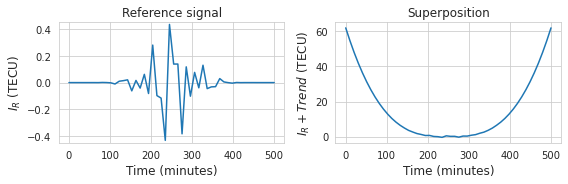

In [265]:
f = plt.figure()
ax1 = f.add_subplot(1, 2, 1)
#ax2 = f.add_subplot(1, 3, 2)
ax2 = f.add_subplot(1, 2, 2)
ax1.plot(t, IR)
#ax2.plot(t, trend)
ax2.plot(t, IR+trend)
ax1.set_title("Reference signal", fontsize="large")
ax1.set_yticks([-0.4, -0.2, 0.0, 0.2, 0.4])
#ax2.set_title("Trend")
ax2.set_title("Superposition", fontsize="large")
ax1.set_ylim(-0.45, 0.45)
ax1.set_xlabel("Time (minutes)", fontsize="large")
ax2.set_xlabel("Time (minutes)", fontsize="large")
ax1.set_ylabel(r"$I_R$ (TECU)", fontsize="large")
ax2.set_ylabel(r"$I_R + Trend$ (TECU)", fontsize="large")
f.set_size_inches(8, 8./3)
f.tight_layout()
f.savefig("./paper/figures/test_signal.pdf")

Create Spline interpolation for superposition

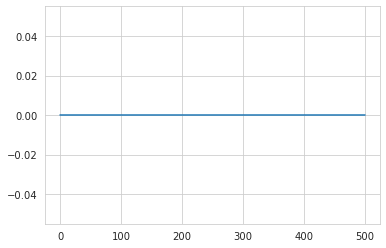

In [266]:
superposition = IR+trend
Sp = CubicSpline(t, superposition)
det_signal = superposition - Sp(t)
plt.plot(t, det_signal)

Clearly the cubic splined interpolation itself reproduces exactly the superimposed signal and the "detrended signal" resulted in no signal at all. We need instead an smoothed cubic spline. But first try with the tools we already count: a Golay-Savitsky filter of order three (since we know in this case that the trend is a cubic polynomial).

In [267]:
from scipy.signal import savgol_filter as savitsky

In [268]:
sav_signal = savitsky(superposition, window_length=11, polyorder=3)
det_signal = superposition - sav_signal

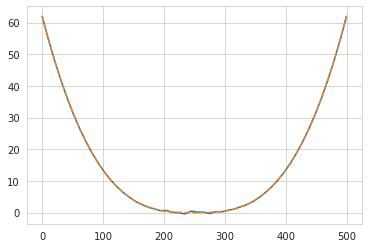

In [269]:
plt.plot(t, superposition)
plt.plot(t, sav_signal, "--")

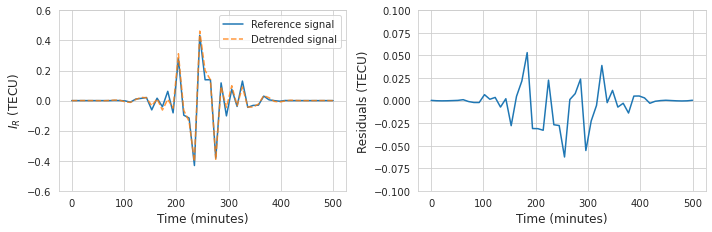

In [270]:
f1 = plt.figure()
bx1 = f1.add_subplot(1, 2, 1)
bx2 = f1.add_subplot(1,2,2)
bx1.plot(t, IR, label="Reference signal")
bx1.plot(t, det_signal, "--", alpha=0.8, label="Detrended signal")
bx1.legend(fontsize="medium")
bx1.set_yticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6])
residuals = IR - det_signal
bx2.plot(t, residuals)
bx1.set_ylim(-0.6, 0.6)
bx2.set_ylim(-0.1, 0.1)
bx1.set_xlabel("Time (minutes)", fontsize="large")
bx2.set_xlabel("Time (minutes)", fontsize="large")
bx1.set_ylabel(r"$I_R$ (TECU)", fontsize="large")
bx2.set_ylabel("Residuals (TECU)", fontsize="large")
f1.set_size_inches(10, 10/3.)
f1.tight_layout()
f1.savefig("./paper/figures/IRvsDetrended.pdf")

## Estimate the best window size option

The last graph showed us that when the window size of the Savitsky-Golay filter is too small or too big the detrending signal differs from the reference signal. In this experiment we will se which window size is optimal, i.e the detrended signal is most similar to the reference signal. To do so, we will estimate the residuals for all possible windows sizes, being the residuals defined as follows:
\begin{align}
r = \sum_{i}\left|I_R(t_i) - det_{IR}(t_i)\right|^2
\end{align}
where $t_i$ is the discretized time and $det_{IR}$ is the detrended signal obtained by substracting from the superimposed signal (trend + reference signal) the Savitsky-Golay fit.

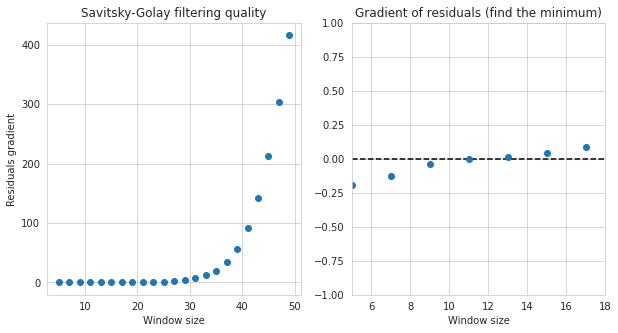

In [271]:
win_size = 5 + 2*np.arange(23) 
residuals = []
for w in win_size:
    res=0
    sav_trend =  savitsky(superposition, window_length=w, polyorder=3)
    det_signal = superposition - sav_trend
    for i, det in enumerate(det_signal):
        res += np.abs(IR[i] - det)**2
    residuals.append(res)
f3 = plt.figure()
cx1 = f3.add_subplot(1, 2, 1)
cx2 = f3.add_subplot(1, 2, 2)
cx1.plot(win_size, residuals, "o")
cx2.axhline(0, c="k", ls="--")
cx1.set_xlabel("Window size")
cx2.set_xlabel("Window size")
cx1.set_ylabel("Residuals")
cx1.set_ylabel("Residuals gradient")
cx1.set_title("Savitsky-Golay filtering quality")
cx2.set_title("Gradient of residuals (find the minimum)")
cx2.plot(win_size, np.gradient(np.array(residuals)), "o")
cx2.set_xlim(5, 18)
cx2.set_ylim(-1, 1)
f3.set_size_inches(10, 5)

Looks like the quality of the fit (measured with the residuals) gets worse as increasing the window size, and the behavior looks exponential. 11 or 13 are the best widow sizes when the time array has 50 elements.

## What happens if we increment the resolution (the time array becomes larger)?

Now we will repeat the experiment but with more resolution (a time array with more elements)

In [272]:
t2 = np.linspace(0, 500, 1000)
IR = A*np.exp(-0.5*(t2-tm)**2/dt**2)*(np.sin(omega1*t2)+np.sin(omega2*t2)+np.sin(omega3*t2))
trend = B*np.abs(t2-t0)**3 
superposition = IR+trend

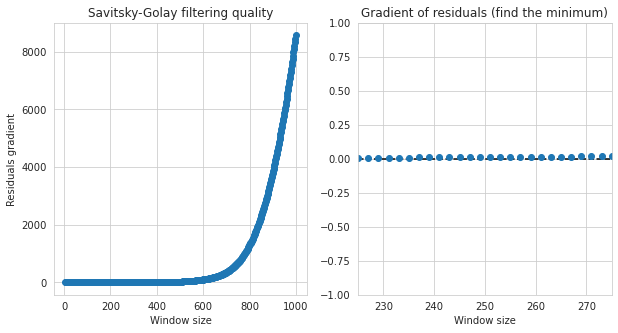

In [273]:
win_size = 5 + 2*np.arange(498) 
residuals = []
for w in win_size:
    res=0
    sav_trend =  savitsky(superposition, window_length=w, polyorder=3)
    det_signal = superposition - sav_trend
    for i, det in enumerate(det_signal):
        res += np.abs(IR[i] - det)**2
    residuals.append(res)
f3 = plt.figure()
cx1 = f3.add_subplot(1, 2, 1)
cx2 = f3.add_subplot(1, 2, 2)
cx1.plot(win_size, residuals, "o")
cx2.axhline(0, c="k", ls="--")
cx1.set_xlabel("Window size")
cx2.set_xlabel("Window size")
cx1.set_ylabel("Residuals")
cx1.set_ylabel("Residuals gradient")
cx1.set_title("Savitsky-Golay filtering quality")
cx2.set_title("Gradient of residuals (find the minimum)")
cx2.plot(win_size, np.gradient(np.array(residuals)), "o")
cx2.set_xlim(225, 275)
cx2.set_ylim(-1, 1)
f3.set_size_inches(10, 5)

This time the best option is a window size about 250. The window size interval is (polyorder, length of array) where the parenthesis mean that this is an open interval (the borders are not included) and window size must be an odd number. If we assume that $f$ is the fraction of the interval length where the fit is optimal, we get that:
\begin{align}
ws_{optimal} = f*(x_{max}-x_{min})
\end{align}
In the 50 points case this is computed as follows:
\begin{align}
ws_{optimal} &= f*(49-5) \approx 11 -- 13 \\
\Rightarrow f \approx 0.25 --0.256
\end{align}
In the case of the 1000 points array we find that:
\begin{align}
ws_{optimal} &= f*(999-5) \approx 230 -- 260 \\
\Rightarrow f \approx 0.23 --0.26
\end{align}
In conclusion, we may take safely the best window size as at the nearest odd number to the quarter of the interval. In this way we may improve significatively the quality of our fit.

## Detrended signal of the 1000 points data

In [274]:
window_size = 0.25*(1000-5)
window_size

248.75

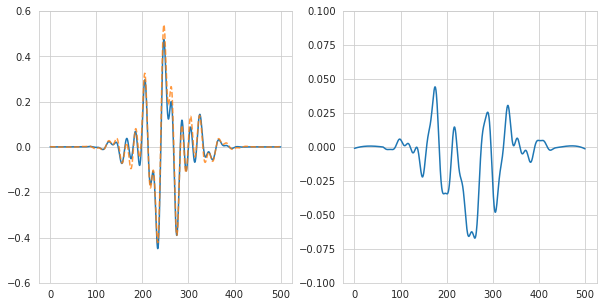

In [275]:
sav_trend =  savitsky(superposition, window_length=249, polyorder=3)
det_signal = superposition - sav_trend
f1 = plt.figure()
bx1 = f1.add_subplot(1, 2, 1)
bx2 = f1.add_subplot(1,2,2)
bx1.plot(t2, IR)
bx1.plot(t2, det_signal, "--", alpha=0.8)
residuals = IR - det_signal
bx2.plot(t2, residuals)
bx1.set_ylim(-0.6, 0.6)
bx2.set_ylim(-0.1, 0.1)
f1.set_size_inches(10, 5)

In [276]:
error = (0.05/0.5)*100
error

10.0

The amplitude of the residual signal is about 10% of the original signal. I'm happy with this

## Smoothing spline interpolation

In [277]:
#from scipy.interpolate import UnivariateSpline

In [278]:
#spline_trend= UnivariateSpline(t2, superposition)

In [279]:
#plt.plot(t2, rec_signal, label="Spline")
#spline_trend.set_smoothing_factor(0.5)
#rec_signal = superposition - spline_trend(t2)
#plt.plot(t2, rec_signal, label="Spline renewed")
#plt.plot(t2, IR, label="Original signal")
#plt.legend()

The smoothing factor may cause us to refresh the resulting curves each time we run the last line, so it does not give consistent results, and they are not better than the Savitsky-Golay filter, which resulted to give both good and consistent results